In [1]:
import exmel
from pathlib import Path

piano = exmel.PianoMidi(Path("mid_files/anhao_transcription.mid"))
melody = exmel.Melody(Path("mid_files/anhao_melody.mid"))

melody

Melody([MelEvent_(time=16.0, note='E3'), ...(550 events)..., MelEvent_(time=263.4, note='E3')])

In [23]:
m = (melody ^ 12)[:389]
m_1 = piano.match_chunk(m, "l2r", local_tolerance=0.2)
print(m_1[0].sum_miss)
part_1 = m_1[0].events

18


In [24]:
m = (melody ^ 12)[389:512]
m_2 = piano.match_chunk(m, "l2r", local_tolerance=0.15)
print(m_2[0].sum_miss)
part_2 = m_2[0].events

29


In [25]:
exmel.save_melody(part_1 + part_2, Path("output.mid"))

In [15]:
exmel.Melody(piano.match_chunk(m, "l2r")[0].events)

Melody([MelEvent_(time=16.7, note='G#4'), ...(345 events)..., MelEvent_(time=197.9, note='G5')])

In [6]:
test = {exmel.MidiEvent(time=16.0, note=60, velocity=100): 2}
test[exmel.MidiEvent(time=8+8, note=60, velocity=100)] = 1
test

{MidiEvent_(time=16.0, note='C4', velocity=100): 1}

In [11]:
t = (0, 1, 2, 3)
t[1:0:-1]

(1,)

In [2]:
exmel.MelEvent_(time=16.0, note='B3')

MelEvent_(time=16.0, note='B3')

In [3]:
piano.nearest(exmel.MelEvent_(time=16.5, note='B3'))

MidiEvent_(time=16.455729166666668, note='B3', velocity=49)

In [12]:
piano.right_nearest(exmel.MelEvent(0, 56))

MidiEvent(time=21.21875, note=56, velocity=59)

# 1

In [1]:
import pretty_midi
import mido
import matplotlib.pyplot as plt

In [ ]:
melody = mido.MidiFile("mid_files/anhao_melody.mid")
piano = mido.MidiFile("mid_files/anhao_transcription.mid")

In [20]:
piano

MidiFile(type=1, ticks_per_beat=384, tracks=[
  MidiTrack([
    MetaMessage('set_tempo', tempo=500000, time=0),
    MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
    MetaMessage('end_of_track', time=1)]),
  MidiTrack([
    Message('control_change', channel=0, control=64, value=127, time=61),
    Message('note_on', channel=0, note=64, velocity=71, time=686),
    Message('note_on', channel=0, note=66, velocity=56, time=191),
    Message('note_on', channel=0, note=68, velocity=71, time=181),
    Message('note_on', channel=0, note=71, velocity=72, time=178),
    Message('control_change', channel=0, control=64, value=0, time=145),
    Message('note_on', channel=0, note=68, velocity=0, time=11),
    Message('note_on', channel=0, note=66, velocity=0, time=0),
    Message('note_on', channel=0, note=71, velocity=0, time=2),
    Message('note_on', channel=0, note=64, velocity=0, time=27),
    Message('note_on', channel=0, n

In [19]:
melody

MidiFile(type=1, ticks_per_beat=480, tracks=[
  MidiTrack([
    MetaMessage('set_tempo', tempo=500000, time=0),
    MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
    MetaMessage('end_of_track', time=1)]),
  MidiTrack([
    Message('program_change', channel=0, program=0, time=0),
    Message('note_on', channel=0, note=52, velocity=77, time=15360),
    Message('note_on', channel=0, note=52, velocity=0, time=230),
    Message('note_on', channel=0, note=56, velocity=77, time=0),
    Message('note_on', channel=0, note=56, velocity=0, time=231),
    Message('note_on', channel=0, note=59, velocity=77, time=0),
    Message('note_on', channel=0, note=59, velocity=0, time=230),
    Message('note_on', channel=0, note=59, velocity=77, time=0),
    Message('note_on', channel=0, note=59, velocity=0, time=231),
    Message('note_on', channel=0, note=56, velocity=77, time=230),
    Message('note_on', channel=0, note=56, velocity=

In [16]:
pretty_midi.PrettyMIDI("mid_files/anhao_transcription.mid").estimate_tempo()

np.float64(241.46507482037745)

In [18]:
pretty_midi.PrettyMIDI("mid_files/anhao_melody.mid").estimate_tempi()

(array([164.07394489, 170.43437093, 149.51330305, 160.92596288,
        132.36307928, 131.90839695, 169.03888481, 168.2570594 ,
        168.51960211, 157.0766294 , 191.04477612, 169.51147734,
        175.37212449, 190.0990099 , 226.87089716, 201.66301969,
        168.97689769, 179.59910913, 117.31160896, 168.17518248,
        152.58278146, 147.56618275, 168.2570594 , 169.74459725,
        168.33901607, 169.82800983, 157.89473684, 140.1459854 ,
        162.98811545, 137.60152891, 105.61056106, 168.91495601,
        144.63276836, 166.83562636, 171.42857143, 169.16299559,
        168.91495601, 142.83942963, 169.03888481, 146.28571429,
        144.63276836, 142.83942963, 113.16306483, 142.9280397 ,
        171.42857143, 166.71490593, 169.03888481, 144.54203262,
        168.91495601, 166.71490593, 169.16299559, 171.30111524,
        166.71490593, 166.59436009, 168.91495601, 187.62214984,
        191.36212625, 191.57427938, 187.4186551 , 150.        ,
        152.51544572, 155.11669659, 150.

In [3]:
import vis

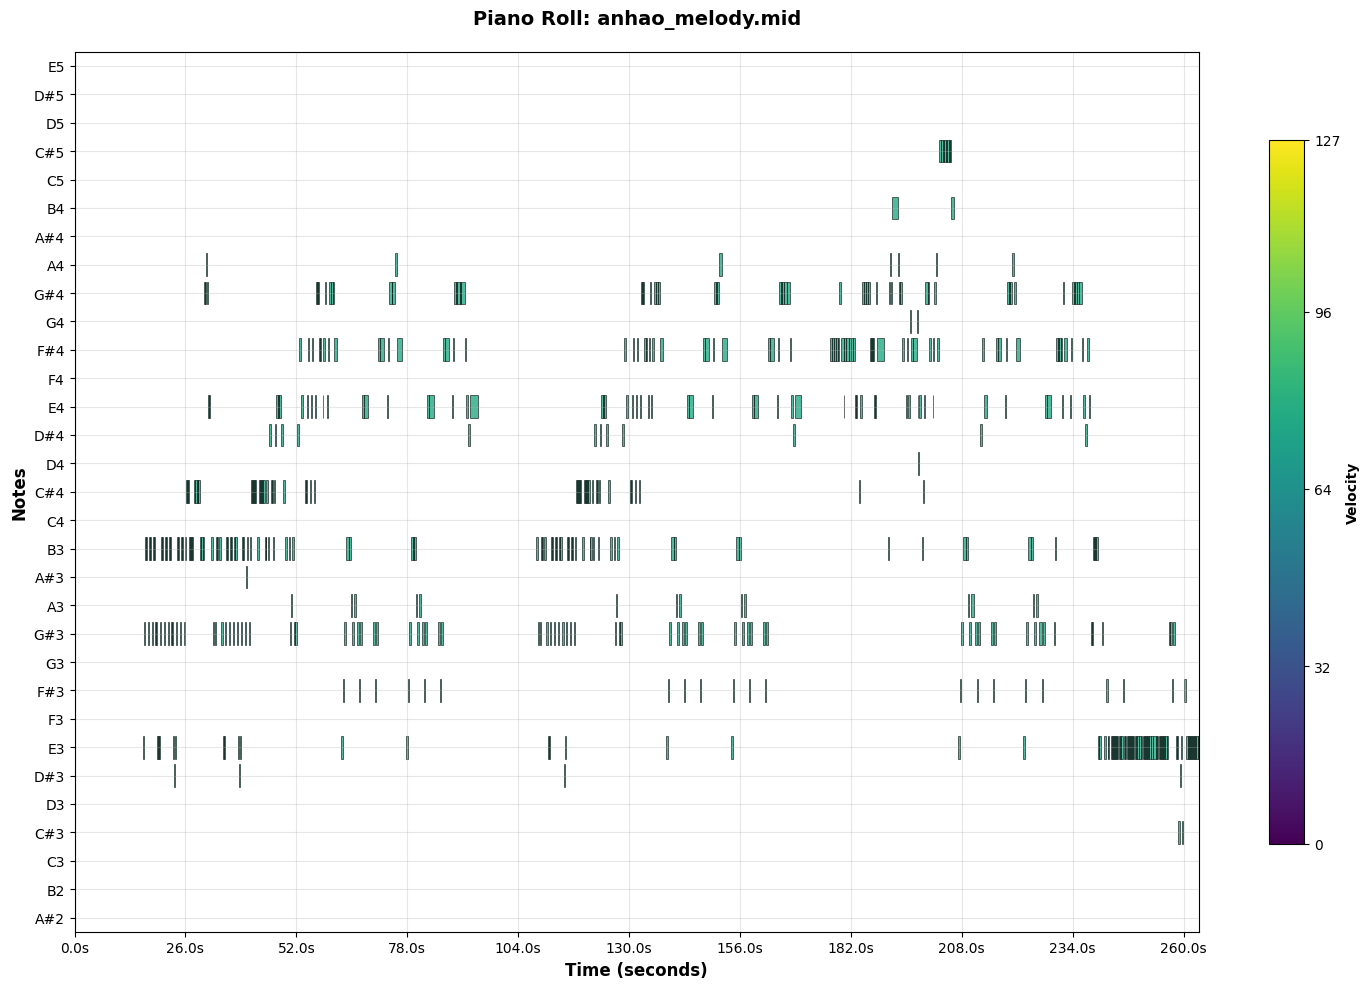

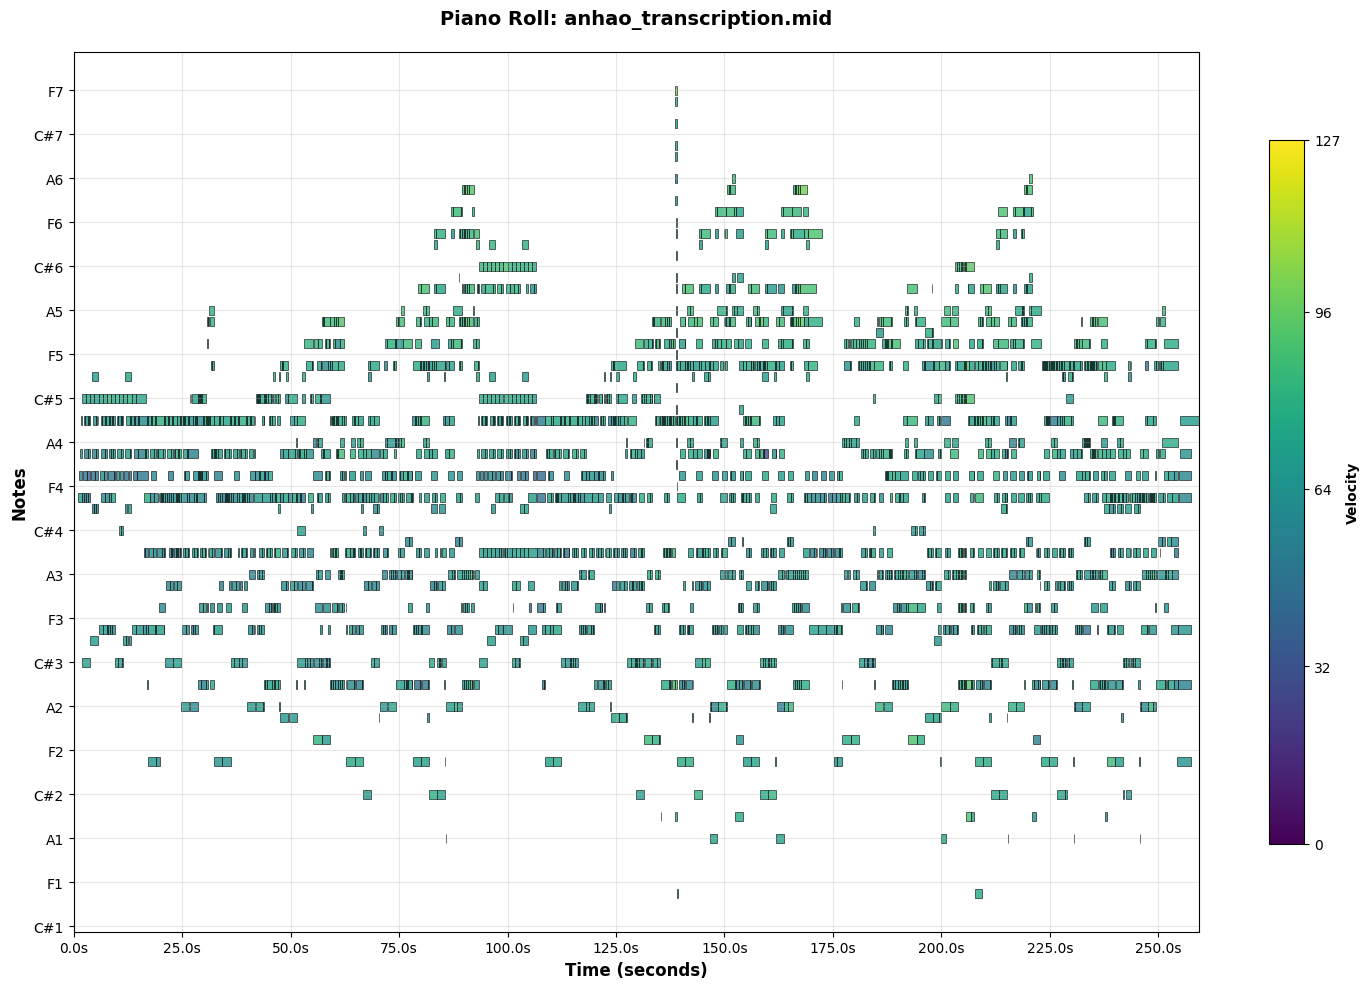

In [11]:
vis.display_midi_piano_roll("mid_files/anhao_melody.mid")
vis.display_midi_piano_roll("mid_files/anhao_transcription.mid")